# 1. Detecting Botnet NetFlow Traffic
<hr>

We got the dataset from the following website: https://mcfp.weebly.com/the-ctu-13-dataset-a-labeled-dataset-with-botnet-normal-and-background-traffic.html

Quoting the website, `The goal of the dataset was to have a large capture of real botnet traffic mixed with normal traffic and background traffic.`

There were 13 Botnet generated traffic in total. We downloaded all the NetFlow datasets and appended them together to perform the training and prediction.

The image below shows the statistic

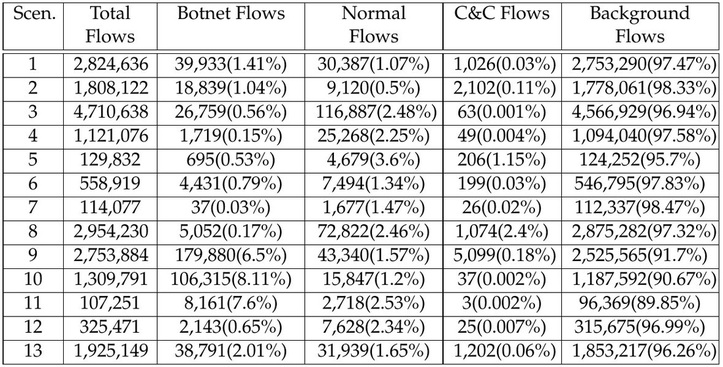

We model the problem such that `Botnet Flows` and `C&C Flows` are Botnet Traffic, while `Normal Flows` and `Background Flows` are non-Botnet Traffic

Our goal is to build a classifier to distinguish Botnet traffic from non-Botnet traffic.

This problem is quite tricky because of the obvious imbalanced data set. The anomalous traffic ranges in the single digit percentages compared to the normal traffic

In [95]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout

import lightgbm as lgb

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, log_loss

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
dtypes = {
    'SrcAddr'    :    'category',
    'DstAddr'    :    'category',
    'Proto'      :    'category',
    'Sport'      :    'category',
    'Dport'      :    'category',
    'State'      :    'category',
    'sTos'       :   'float64',
    'dTos'       :   'float64',
    'SrcWin'     :   'float64',
    'DstWin'     :   'float64',
    'sHops'      :   'float64',
    'dHops'      :   'float64',
    'StartTime'  :    'category',
    'LastTime'   :    'category',
    'sTtl'       :   'float64',
    'dTtl'       :   'float64',
    'TcpRtt'     :   'float64',
    'SynAck'     :   'float64',
    'AckDat'     :   'float64',
    'SrcPkts'    :     'int64',
    'DstPkts'    :     'int64',
    'SrcBytes'   :     'int64',
    'DstBytes'   :     'int64',
    'SAppBytes'  :     'int64',
    'DAppBytes'  :     'int64',
    'Dur'        :   'float64',
    'TotPkts'    :    'int64',
    'TotBytes'   :     'int64',
    'TotAppByte' :     'int64',
    'Rate'       :   'float64',
    'SrcRate'    :   'float64',
    'DstRate'    :   'float64',
}

In [4]:
df_train = pd.read_csv("allnetflow.csv", dtype=dtypes)

In [5]:
df_train.head()

,SrcAddr,DstAddr,Proto,Sport,Dport,State,sTos,dTos,SrcWin,DstWin,...,SAppBytes,DAppBytes,Dur,TotPkts,TotBytes,TotAppByte,Rate,SrcRate,DstRate,Label
0,195.68.34.68,147.32.86.165,tcp,52475,12114,RST,0.0,0.0,524280.0,2097152.0,...,0,0,11.337043,11,824,0,0.882064,0.617445,0.222212,flow=Background-TCP-Established
1,147.32.86.58,77.75.73.156,tcp,1393,80,RST,0.0,0.0,65535.0,7566.0,...,0,0,2.962470,3,182,0,0.675112,0.337556,0.000000,flow=Background-TCP-Attempt
2,201.54.33.206,147.32.86.110,tcp,2550,443,RST,0.0,0.0,16000.0,0.0,...,0,0,2.962828,4,240,0,1.012546,0.337515,0.719519,flow=Background-TCP-Attempt
3,221.134.221.114,147.32.84.189,tcp,8204,51413,RST,0.0,0.0,32768.0,0.0,...,0,0,1.986249,4,252,0,1.510385,0.503462,1.009261,flow=Background-TCP-Attempt
4,147.32.84.59,147.32.80.7,tcp,49156,80,RST,0.0,0.0,16384.0,65696.0,...,246,2652,767.978638,14,3710,2898,0.016928,0.010417,0.224661,flow=Background-Established-cmpgw-CVUT


In [6]:
df_train['isBotnet'] = df_train['Label'].apply(lambda x : 1 if 'Botnet' in x else 0)

In [7]:
len(df_train[df_train['isBotnet'] == 1])
len(df_train[df_train['isBotnet'] == 0])

382797

14961145

We have 382,797 Botnet Traffic, and 14,961,145 non-Botnet traffic

# 2. Removing all Src information, and some Dst information
<hr>

Since the NetFlow information comes from companies sending network data to the ISP itself, we essentially lose all source information. This is because the source information becomes just the company gateway, making it useless, and we should drop all of it.

We remove some destination information as well (DstAddr, DstWin, DstPort), because we cannot be certain what the destination port and address of the C2 is, which would highly likely be dynamic.

We try to model the prediction problem to be based solely on network behavior, leaving out end point information.

In [8]:
X = df_train.drop(['isBotnet', 'Label', 'SrcAddr', 'SrcWin', 'DstAddr', 'DstWin', 'Sport', 'Dport', \
                   'SrcPkts', 'SrcBytes', 'SAppBytes', 'sTos', 'sHops', 'sTtl', 'SrcRate' ], axis=1)
y = df_train['isBotnet']

# 3. Creating datasets
<hr>

In [9]:
from sklearn.model_selection import train_test_split

# Creating training, validation and testing sets

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.33, random_state=42, stratify=y_train1)

In [110]:
dtypes2 = {
    'Proto'      :    'category',
    'State'      :    'category',
    'dTos'       :   'float64',
    'dHops'      :   'float64',
    'StartTime'  :    'category',
    'LastTime'   :    'category',
    'dTtl'       :   'float64',
    'TcpRtt'     :   'float64',
    'SynAck'     :   'float64',
    'AckDat'     :   'float64',
    'DstPkts'    :     'int64',
    'DstBytes'   :     'int64',
    'DAppBytes'  :     'int64',
    'Dur'        :   'float64',
    'TotPkts'    :    'int64',
    'TotBytes'   :     'int64',
    'TotAppByte' :     'int64',
    'Rate'       :   'float64',
    'DstRate'    :   'float64',
}

X_train2 = X_train2.astype(dtype=dtypes2)

In [150]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([6716057,  171838], dtype=int64))

## Final data sets to use:
```
X_train, y_train

X_valid, y_valid

X_test, y_test
```

# 4. LightGBM
<hr>

In [154]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params = {
    'objective' :'binary',
    'learning_rate' : 0.01,
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'auc'
}

model = lgb.train(params,
                       train_data,
                       valid_sets=valid_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100,
                 verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.0513857
[200]	valid_0's binary_logloss: 0.0410855
[300]	valid_0's binary_logloss: 0.0371336
[400]	valid_0's binary_logloss: 0.0351721
[500]	valid_0's binary_logloss: 0.0337951
[600]	valid_0's binary_logloss: 0.0327568
[700]	valid_0's binary_logloss: 0.0319797
[800]	valid_0's binary_logloss: 0.0313616
[900]	valid_0's binary_logloss: 0.0308045
[1000]	valid_0's binary_logloss: 0.0303254
[1100]	valid_0's binary_logloss: 0.0299447
[1200]	valid_0's binary_logloss: 0.0296275
[1300]	valid_0's binary_logloss: 0.0293159
[1400]	valid_0's binary_logloss: 0.0290347
[1500]	valid_0's binary_logloss: 0.0287839
[1600]	valid_0's binary_logloss: 0.0285476
[1700]	valid_0's binary_logloss: 0.0283448
[1800]	valid_0's binary_logloss: 0.0281539
[1900]	valid_0's binary_logloss: 0.027976
[2000]	valid_0's binary_logloss: 0.0278237
[2100]	valid_0's binary_logloss: 0.027691
[2200]	valid_0's binary_logloss: 0.0275454
[2

In [155]:
preds = model.predict(X_test)

# tranforming the predictions to 1 and 0
predictions_lgbm_01 = np.where(preds > 0.4, 1, 0)

In [157]:

"Accuracy: " + str(accuracy_score(y_test, predictions_lgbm_01))
confusion_matrix(y_test, predictions_lgbm_01)
"Precision: " + str(precision_score(y_test, predictions_lgbm_01))
"Recall: " + str(recall_score(y_test, predictions_lgbm_01))
"AUC: " + str(roc_auc_score(y_test, predictions_lgbm_01))

'Accuracy: 0.9894681565185827'

array([[4920482,   16696],
       [  36632,   89691]], dtype=int64)

'Precision: 0.8430635321984828'

'Recall: 0.7100132200786872'

'AUC: 0.8533157655933868'

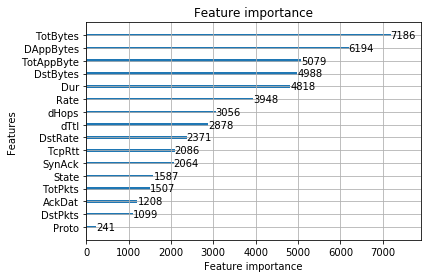

In [141]:
lgb.plot_importance(model)

## Analysis of Graph

From the feature importance graph, we can see that the Byte information all ranks the highest.

We consider this a success because the final feature importance comes from network behavior, which is exactly how we modeled the problem in the first place by removing most end point information.

## Analysis of Results


At first glance, a `98%` accuracy in prediciting if a traffic is part of a Botnet traffic, which is pretty good.

But when we look at the Recall and Precision, we see that it's an average performance

The Precision is `84%`, while the Recall value is `71%`

We would like to have a higher level of recall, as the cost of False Positives is cheap (If we say that the traffic is anomalous when it is not, nothing bad is going to happen. At most, the analyst will have to look at more data).

Having a higher level of Recall is more desirable, as we want to catch all the anomalous traffic. Letting `29%` of the anomalous traffic slip through is quite bad.

# 5. Processing the data set for numerical calculation
<hr>

In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

X_train_num = X_train.copy()
X_test_num = X_test.copy()

X_train_num.drop(['StartTime', 'LastTime'], axis=1, inplace=True)
X_test_num.drop(['StartTime', 'LastTime'], axis=1, inplace=True)

X_train_num = X_train_num.fillna(X_train_num.mode().iloc[0])
X_test_num = X_test_num.fillna(X_test_num.mode().iloc[0])

X_train_num['Proto'] = le.fit_transform(X_train_num['Proto'])
X_train_num['State'] = le.fit_transform(X_train_num['State'])

X_test_num['Proto'] = le.fit_transform(X_test_num['Proto'])
X_test_num['State'] = le.fit_transform(X_test_num['State'])

# 6 Random Forest
<hr>

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=10,
                              random_state=0)

clf.fit(X_train_num, y_train)
predictions_rf_01 = clf.predict(X_test_num)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
"Accuracy: " + str(accuracy_score(y_test, predictions_rf_01))
confusion_matrix(y_test, predictions_rf_01)
"Precision: " + str(precision_score(y_test, predictions_rf_01))
"Recall: " + str(recall_score(y_test, predictions_rf_01))
"AUC: " + str(roc_auc_score(y_test, predictions_rf_01))

'Accuracy: 0.987060533808525'

array([[4935513,    1665],
       [  63854,   62469]], dtype=int64)

'Precision: 0.9740387314061184'

'Recall: 0.4945180212629529'

'AUC: 0.7470903920400462'

## Analysis of Results

Using Random Forest, we get a very good Precision improvement to `97%`, but our Recall drops significantly to `49%`.

This is worse, as we want a higher Recall at the expense (not much) of precision. Random forest gives us the opposite result

# 7. Training the Model (Neural Networks)
<hr>

## Oversampling the data

In [58]:
sos = SMOTE()
X_train_os, y_train_os = sos.fit_resample(X_train_num, y_train)

In [131]:
model = Sequential()
model.add(Dense(32, input_dim=17, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [132]:
model.fit(X_train_os, y_train_os, epochs=10, batch_size=4026)

Epoch 1/10
13432114/13432114 [==============================] - 19s 1us/step - loss: 0.2790 - acc: 0.8874
Epoch 2/10
13432114/13432114 [==============================] - 18s 1us/step - loss: 0.2235 - acc: 0.9114
Epoch 3/10
13432114/13432114 [==============================] - 18s 1us/step - loss: 0.2117 - acc: 0.9157
Epoch 4/10
13432114/13432114 [==============================] - 18s 1us/step - loss: 0.2089 - acc: 0.9172
Epoch 5/10
13432114/13432114 [==============================] - 17s 1us/step - loss: 0.2026 - acc: 0.9198
Epoch 6/10
13432114/13432114 [==============================] - 18s 1us/step - loss: 0.2010 - acc: 0.9205
Epoch 7/10
13432114/13432114 [==============================] - 18s 1us/step - loss: 0.2009 - acc: 0.9206
Epoch 8/10
13432114/13432114 [==============================] - 18s 1us/step - loss: 0.1977 - acc: 0.9216
Epoch 9/10
13432114/13432114 [==============================] - 18s 1us/step - loss: 0.1949 - acc: 0.9231
Epoch 10/10
13432114/13432114 [===============

In [126]:
model.fit(X_train_os, y_train_os, epochs=10, batch_size=4026)

Epoch 1/10
13432114/13432114 [==============================] - 27s 2us/step - loss: 0.2427 - acc: 0.9023
Epoch 2/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.2089 - acc: 0.9156
Epoch 3/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.2009 - acc: 0.9199
Epoch 4/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.1958 - acc: 0.9224
Epoch 5/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.1941 - acc: 0.9224
Epoch 6/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.1907 - acc: 0.9239
Epoch 7/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.1966 - acc: 0.9221
Epoch 8/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.1893 - acc: 0.9237
Epoch 9/10
13432114/13432114 [==============================] - 26s 2us/step - loss: 0.1871 - acc: 0.9249
Epoch 10/10
13432114/13432114 [===============

In [133]:
predictions_nn_01 = model.predict(X_test_num)

predictions_nn = np.where(predictions_nn_01 > 0.5, 1, 0)

"Accuracy: " + str(accuracy_score(y_test, predictions_nn))
confusion_matrix(y_test, predictions_nn)
"Precision: " + str(precision_score(y_test, predictions_nn))
"Recall: " + str(recall_score(y_test, predictions_nn))
"AUC: " + str(roc_auc_score(y_test, predictions_nn))

'Accuracy: 0.9484773479851194'

array([[4687188,  249990],
       [  10895,  115428]], dtype=int64)

'Precision: 0.3158793491289427'

'Recall: 0.9137528399420534'

'AUC: 0.9315593258739534'

## Analysis of Results

Using Neural Networks, we see that the Recall is much higher, hitting `91%`. This is at the expense of Precision, which is `23%`.

This means that for all the traffic we identify as anomalous, `32%` of it actually is anomalous. And of the `32%` that we picked out, it consists of `91%` of the total anomalous traffic.

# 8. Ensembling (LGBM + RF + NN)
<hr>

todo...